# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [18]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [19]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [20]:
## load dataset here
df = pd.read_csv("../data/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [21]:
## parsing data here
images, labels = parse_data(df)


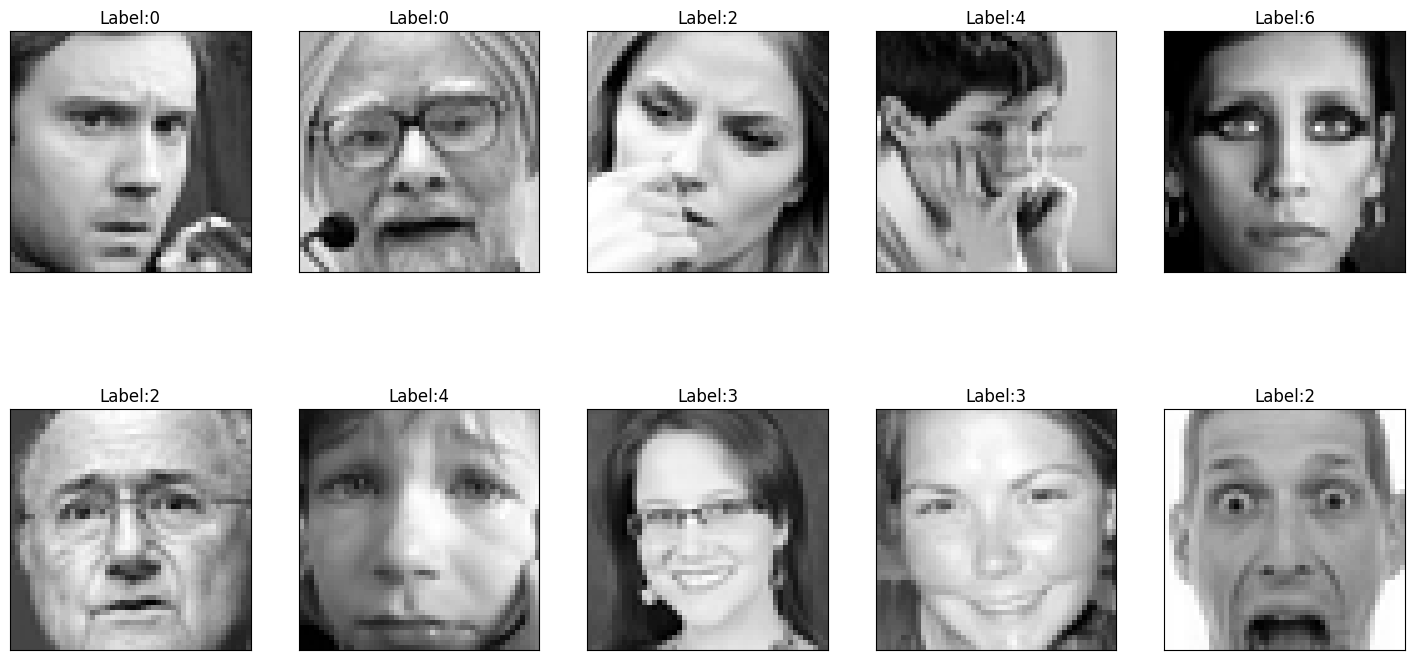

In [22]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [23]:
from sklearn.decomposition import PCA
# Reshape dữ liệu ảnh vào dạng (số lượng mẫu, số lượng features)
images_reshaped = images.reshape(images.shape[0], -1)

# Áp dụng PCA để giảm chiều dữ liệu xuống còn 2
pca = PCA(n_components=2)
images_pca = pca.fit_transform(images_reshaped)
images_pca.shape

(35887, 2)

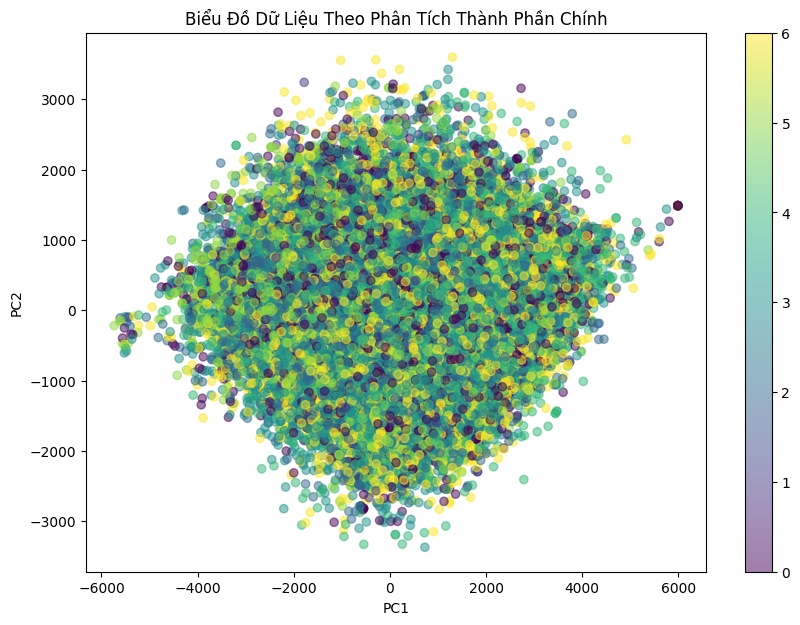

In [24]:
## transform for visualizing here
plt.figure(figsize=(10, 7))
plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('Biểu Đồ Dữ Liệu Theo Phân Tích Thành Phần Chính')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

Số lượng thành phần chính tối ưu để giữ lại 95.0% thông tin là: 255


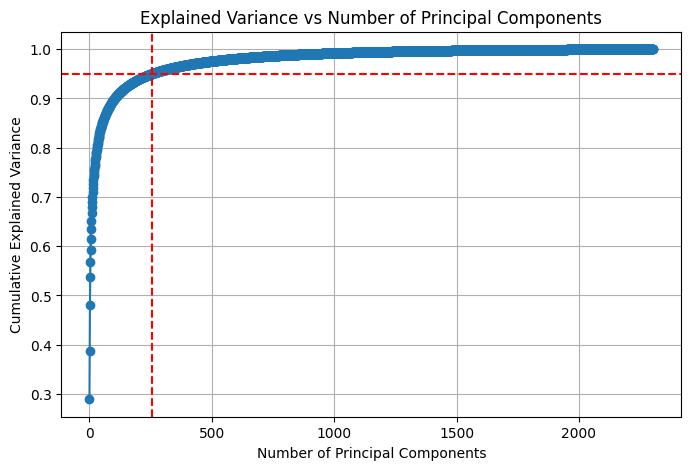

In [25]:
## determine the optimal number of PCs here
## pca.explained_variance_()
pca = PCA().fit(images_reshaped)  # Bạn cần phải có biến images_reshaped đã được prepare từ trước

# Tích lũy giải thích phương sai để xác định số lượng PCs
variance_explained_cumulative = np.cumsum(pca.explained_variance_ratio_)

# Vẽ biểu đồ tích lũy giải thích phương sai để xác định PCs tối ưu
plt.figure(figsize=(8, 5))
plt.plot(variance_explained_cumulative, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Principal Components')
plt.grid(True)

# Đặt ngưỡng để chọn số lượng PC (ví dụ: 0.95 cho 95%)
threshold = 0.95
optimal_num_components = np.where(variance_explained_cumulative >= threshold)[0][0] + 1  # +1 vì index bắt đầu từ 0

print(f'Số lượng thành phần chính tối ưu để giữ lại {threshold*100}% thông tin là: {optimal_num_components}')

# Hiển thị biểu đồ
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axvline(x=optimal_num_components, color='r', linestyle='--')
plt.show()



Explaination :

Để tìm ra số lượng thành phần chính lý tưởng trong phân tích dữ liệu, chúng ta sẽ đi qua ba bước chính. Đầu tiên, một mô hình PCA được áp dụng để phân tích tập dữ liệu, từ đó xác định tỷ lệ phương sai mà mỗi thành phần chính giải thích được. Tiếp theo, chúng ta tính toán phương sai tích lũy, cho biết tổng lượng thông tin được giữ lại khi thêm dần các thành phần.

Điểm mấu chốt là tìm ra số lượng thành phần chính tối thiểu cần thiết để giải thích một tỷ lệ đáng kể của phương sai, thường là 95%. Nói cách khác, chúng ta muốn giảm thiểu số chiều dữ liệu trong khi vẫn đảm bảo rằng phần lớn thông tin quan trọng được giữ lại.

Để dễ hình dung, chúng ta có thể biểu diễn quá trình này trên một biểu đồ, với trục hoành là số lượng thành phần chính và trục tung là phương sai tích lũy. Biểu đồ sẽ cho thấy phương sai tích lũy tăng nhanh ban đầu và sau đó chậm lại, cho thấy rằng những thành phần đầu tiên đóng góp nhiều nhất vào việc giải thích dữ liệu. Số lượng thành phần chính tối ưu sẽ tương ứng với điểm trên biểu đồ mà tại đó phương sai tích lũy đạt đến ngưỡng 95%.

Bằng cách xác định và sử dụng số lượng thành phần chính tối ưu, chúng ta có thể giảm đáng kể kích thước của dữ liệu mà không làm mất đi quá nhiều thông tin quan trọng. Điều này không chỉ giúp đơn giản hóa quá trình phân tích mà còn cải thiện hiệu suất của các thuật toán học máy tiếp theo.

In [26]:
variance_explained_cumulative

array([0.2892651 , 0.387289  , 0.48154432, ..., 0.99999913, 0.99999958,
       1.        ])

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

ORIGINAL DATASET :

In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from joblib import parallel_backend
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

     

In [73]:
# splitting data into train/val/test subsets here
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [74]:
from skimage.transform import resize

# Function to resize imagesa
def resize_images(images, new_size=(24, 24)):
    resized_images = np.zeros((images.shape[0], new_size[0], new_size[1]))
    for i in range(images.shape[0]):
        resized_images[i] = resize(images[i], new_size, anti_aliasing=True)
    return resized_images

# Resizing the images
X_train_resized = resize_images(X_train, new_size=(24, 24))
X_test_resized = resize_images(X_test, new_size=(24, 24))


In [75]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model


# Prepare data for CNN
X_train_cnn = X_train_resized[..., np.newaxis]
X_test_cnn = X_test_resized[..., np.newaxis]
input_shape = X_train_cnn.shape[1:]

# Define a simple CNN model for feature extraction
def build_cnn(input_shape):
    inputs = Input(shape=input_shape)  # Explicitly define input layer
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)  # Use 'same' padding to preserve image size
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    outputs = Dense(128, activation='relu')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build the CNN model
cnn_model = build_cnn(input_shape)

# Extract features using the CNN - no need to compile if not training
cnn_feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)  # Output before the Flatten layer
X_train_features = cnn_feature_extractor.predict(X_train_cnn)
X_test_features = cnn_feature_extractor.predict(X_test_cnn)

898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from joblib import parallel_backend

# Scale the extracted features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

In [77]:
# Mô hình Hồi quy Logistic
model_lr = LogisticRegression(max_iter=2000)
param_grid_lr = {'C': [0.1, 1, 10]}

grid_search_lr = GridSearchCV(model_lr, param_grid_lr, cv=5, n_jobs=-1)
grid_search_lr.fit(X_train_scaled, y_train)

print("Hồi quy Logistic - Kết quả:")
print(f"Tham số tốt nhất: {grid_search_lr.best_params_}")
print("Báo cáo phân loại:")
print(classification_report(y_test, grid_search_lr.predict(X_test_scaled)))

Hồi quy Logistic - Kết quả:
Tham số tốt nhất: {'C': 0.1}
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.34      0.30      0.32       985
           1       0.38      0.39      0.39       102
           2       0.32      0.27      0.29      1043
           3       0.54      0.65      0.59      1765
           4       0.31      0.30      0.30      1210
           5       0.57      0.57      0.57       795
           6       0.40      0.40      0.40      1278

    accuracy                           0.43      7178
   macro avg       0.41      0.41      0.41      7178
weighted avg       0.42      0.43      0.42      7178



In [78]:
# Mô hình Cây Quyết định
model_dt = DecisionTreeClassifier()
param_grid_dt = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}

grid_search_dt = GridSearchCV(model_dt, param_grid_dt, cv=5, n_jobs=-1)
grid_search_dt.fit(X_train_scaled, y_train)

print("Cây Quyết định - Kết quả:")
print(f"Tham số tốt nhất: {grid_search_dt.best_params_}")
print("Báo cáo phân loại:")
print(classification_report(y_test, grid_search_dt.predict(X_test_scaled)))

Cây Quyết định - Kết quả:
Tham số tốt nhất: {'max_depth': 10, 'min_samples_split': 5}
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.21      0.19      0.20       985
           1       0.21      0.03      0.05       102
           2       0.24      0.18      0.21      1043
           3       0.40      0.53      0.46      1765
           4       0.27      0.27      0.27      1210
           5       0.44      0.34      0.38       795
           6       0.29      0.31      0.30      1278

    accuracy                           0.32      7178
   macro avg       0.30      0.26      0.27      7178
weighted avg       0.31      0.32      0.31      7178



In [79]:
# Mô hình Rừng Ngẫu nhiên
model_rf = RandomForestClassifier()
param_grid_rf = {'n_estimators': [50, 100, 200]}

grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=5, n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

print("Rừng Ngẫu nhiên - Kết quả:")
print(f"Tham số tốt nhất: {grid_search_rf.best_params_}")
print("Báo cáo phân loại:")
print(classification_report(y_test, grid_search_rf.predict(X_test_scaled)))

Rừng Ngẫu nhiên - Kết quả:
Tham số tốt nhất: {'n_estimators': 200}
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.54      0.22      0.32       985
           1       0.94      0.30      0.46       102
           2       0.54      0.30      0.39      1043
           3       0.43      0.80      0.56      1765
           4       0.40      0.40      0.40      1210
           5       0.71      0.57      0.63       795
           6       0.46      0.36      0.41      1278

    accuracy                           0.47      7178
   macro avg       0.57      0.42      0.45      7178
weighted avg       0.50      0.47      0.45      7178



In [80]:
# Mô hình Mạng Nơ-ron (MLP)
model_mlp = MLPClassifier(max_iter=1000, early_stopping=True, n_iter_no_change=10)
param_grid_mlp = {'hidden_layer_sizes': [(50,), (100,), (50,50)], 'alpha': [0.0001, 0.001]}

grid_search_mlp = GridSearchCV(model_mlp, param_grid_mlp, cv=5, n_jobs=-1)
grid_search_mlp.fit(X_train_scaled, y_train)

print("Mạng Nơ-ron (MLP) - Kết quả:")
print(f"Tham số tốt nhất: {grid_search_mlp.best_params_}")
print("Báo cáo phân loại:")
print(classification_report(y_test, grid_search_mlp.predict(X_test_scaled)))

Mạng Nơ-ron (MLP) - Kết quả:
Tham số tốt nhất: {'alpha': 0.001, 'hidden_layer_sizes': (100,)}
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.36      0.34      0.35       985
           1       0.46      0.39      0.42       102
           2       0.41      0.31      0.35      1043
           3       0.57      0.65      0.61      1765
           4       0.35      0.35      0.35      1210
           5       0.63      0.58      0.60       795
           6       0.40      0.43      0.42      1278

    accuracy                           0.46      7178
   macro avg       0.45      0.44      0.44      7178
weighted avg       0.46      0.46      0.46      7178



In [39]:
import re

def extract_accuracy_from_report(report):
    accuracy_line = re.search(r"accuracy\s+(\d+\.\d+)", report)
    if accuracy_line:
        return float(accuracy_line.group(1))
    else:
        return None

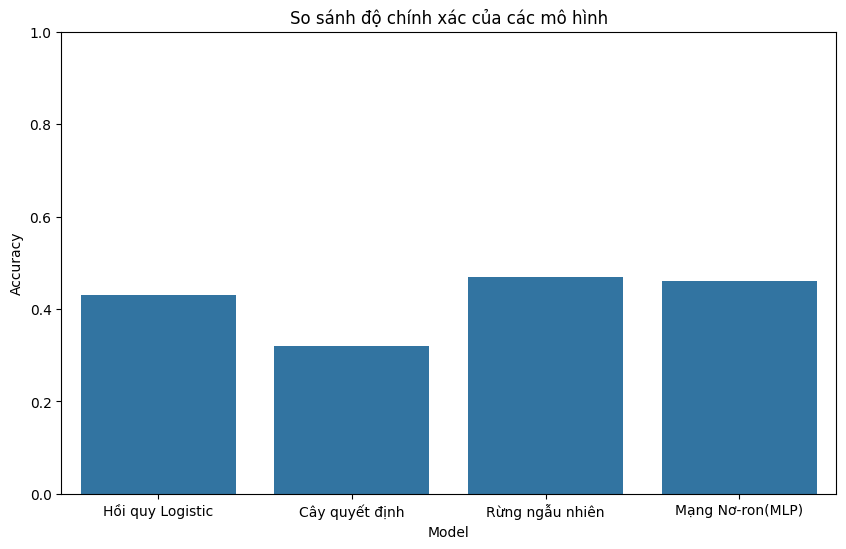

In [81]:
import seaborn as sns

accuracies = [
    extract_accuracy_from_report(classification_report(y_test, grid_search_lr.predict(X_test_scaled))),
    extract_accuracy_from_report(classification_report(y_test, grid_search_dt.predict(X_test_scaled))),
    extract_accuracy_from_report(classification_report(y_test, grid_search_rf.predict(X_test_scaled))),
    extract_accuracy_from_report(classification_report(y_test, grid_search_mlp.predict(X_test_scaled)))
]
models = ['Hồi quy Logistic', 'Cây quyết định','Rừng ngẫu nhiên', 'Mạng Nơ-ron(MLP)']

df = pd.DataFrame({'Model': models, 'Accuracy': accuracies})

# Vẽ biểu đồ so sánh độ chính xác
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=df)
plt.title('So sánh độ chính xác của các mô hình')
plt.ylabel('Accuracy')
plt.ylim([0, 1]) 
plt.show()

In [57]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [58]:
pca = PCA(n_components=255)  # Example reduction to 255 components
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)

In [62]:
# Mô hình Hồi quy Logistic
model_lr = LogisticRegression(max_iter=2000)
param_grid_lr_pca = {'C': [0.1, 1, 10]}

grid_search_lr_pca = GridSearchCV(model_lr, param_grid_lr_pca, cv=5, n_jobs=-1)
grid_search_lr_pca.fit(X_train_scaled, y_train)

print("Hồi quy Logistic - Kết quả:")
print(f"Tham số tốt nhất: {grid_search_lr_pca.best_params_}")
print("Báo cáo phân loại:")
print(classification_report(y_test, grid_search_lr_pca.predict(X_test_scaled)))

Hồi quy Logistic - Kết quả:
Tham số tốt nhất: {'C': 0.1}
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.28      0.16      0.20       985
           1       0.20      0.04      0.07       102
           2       0.25      0.14      0.18      1043
           3       0.43      0.68      0.53      1765
           4       0.28      0.28      0.28      1210
           5       0.46      0.46      0.46       795
           6       0.36      0.33      0.35      1278

    accuracy                           0.37      7178
   macro avg       0.32      0.30      0.29      7178
weighted avg       0.35      0.37      0.34      7178



In [69]:
# Mô hình Cây Quyết định
model_dt = DecisionTreeClassifier()
param_grid_dt_pca = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}

grid_search_dt_pca = GridSearchCV(model_dt, param_grid_dt_pca, cv=5, n_jobs=-1)
grid_search_dt_pca.fit(X_train_scaled, y_train)

print("Cây Quyết định - Kết quả:")
print(f"Tham số tốt nhất: {grid_search_dt_pca.best_params_}")
print("Báo cáo phân loại:")
print(classification_report(y_test,grid_search_dt_pca.predict(X_test_scaled)))

Cây Quyết định - Kết quả:
Tham số tốt nhất: {'max_depth': 10, 'min_samples_split': 2}
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.20      0.15      0.17       985
           1       0.43      0.03      0.06       102
           2       0.24      0.17      0.20      1043
           3       0.35      0.57      0.43      1765
           4       0.24      0.26      0.25      1210
           5       0.40      0.26      0.32       795
           6       0.26      0.20      0.22      1278

    accuracy                           0.29      7178
   macro avg       0.30      0.23      0.23      7178
weighted avg       0.28      0.29      0.28      7178



In [63]:
model_rf = RandomForestClassifier()
param_grid_rf_pca = {'n_estimators': [50, 100, 200]}

grid_search_rf_pca = GridSearchCV(model_rf, param_grid_rf_pca, cv=5, n_jobs=-1)
grid_search_rf_pca.fit(X_train_scaled, y_train)

print("Rừng Ngẫu nhiên - Kết quả:")
print(f"Tham số tốt nhất: {grid_search_rf_pca.best_params_}")
print("Báo cáo phân loại:")
print(classification_report(y_test, grid_search_rf_pca.predict(X_test_scaled)))

Rừng Ngẫu nhiên - Kết quả:
Tham số tốt nhất: {'n_estimators': 200}
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.58      0.13      0.22       985
           1       0.93      0.26      0.41       102
           2       0.59      0.22      0.32      1043
           3       0.34      0.87      0.49      1765
           4       0.34      0.24      0.28      1210
           5       0.81      0.43      0.56       795
           6       0.40      0.23      0.29      1278

    accuracy                           0.40      7178
   macro avg       0.57      0.34      0.37      7178
weighted avg       0.48      0.40      0.36      7178



In [64]:
# Mô hình Mạng Nơ-ron (MLP)
model_mlp = MLPClassifier(max_iter=1000, early_stopping=True, n_iter_no_change=10)
param_grid_mlp_pca = {'hidden_layer_sizes': [(50,), (100,), (50,50)], 'alpha': [0.0001, 0.001]}

grid_search_mlp_pca = GridSearchCV(model_mlp, param_grid_mlp_pca, cv=5, n_jobs=-1)
grid_search_mlp_pca.fit(X_train_scaled, y_train)

print("Mạng Nơ-ron (MLP) - Kết quả:")
print(f"Tham số tốt nhất: {grid_search_mlp_pca.best_params_}")
print("Báo cáo phân loại:")
print(classification_report(y_test, grid_search_mlp_pca.predict(X_test_scaled)))

Mạng Nơ-ron (MLP) - Kết quả:
Tham số tốt nhất: {'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.31      0.26      0.28       985
           1       0.49      0.20      0.28       102
           2       0.28      0.24      0.26      1043
           3       0.50      0.63      0.56      1765
           4       0.30      0.30      0.30      1210
           5       0.52      0.51      0.51       795
           6       0.35      0.33      0.34      1278

    accuracy                           0.39      7178
   macro avg       0.39      0.35      0.36      7178
weighted avg       0.38      0.39      0.38      7178



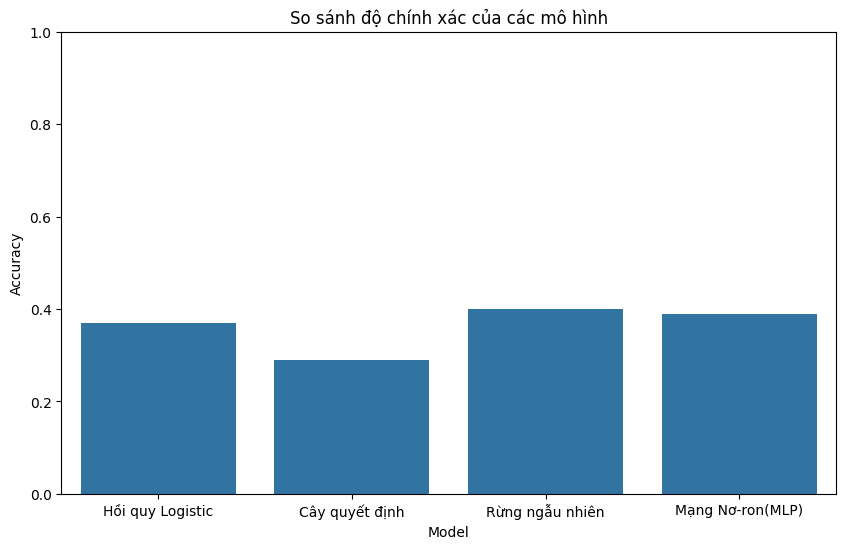

In [71]:
import seaborn as sns

accuracies = [
    extract_accuracy_from_report(classification_report(y_test, grid_search_lr_pca.predict(X_test_scaled))),
    extract_accuracy_from_report(classification_report(y_test, grid_search_dt_pca.predict(X_test_scaled))),
    extract_accuracy_from_report(classification_report(y_test, grid_search_rf_pca.predict(X_test_scaled))),
    extract_accuracy_from_report(classification_report(y_test, grid_search_mlp_pca.predict(X_test_scaled)))
]

models = ['Hồi quy Logistic', 'Cây quyết định','Rừng ngẫu nhiên', 'Mạng Nơ-ron(MLP)']

df = pd.DataFrame({'Model': models, 'Accuracy': accuracies})

# Vẽ biểu đồ so sánh độ chính xác
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=df)
plt.title('So sánh độ chính xác của các mô hình')
plt.ylabel('Accuracy')
plt.ylim([0, 1]) 
plt.show()

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



In [88]:
## visualize the confusion matrices and classification reports here# Compare performance and identify best model
model_metrics = {
    'Hồi quy Logistic': classification_report(y_test, grid_search_lr.predict(X_test_scaled), output_dict=True),
    'Cây quyết định': classification_report(y_test, grid_search_dt.predict(X_test_scaled), output_dict=True),
    'Rừng ngẫu nhiên': classification_report(y_test, grid_search_rf.predict(X_test_scaled), output_dict=True),
    'Mạng Nơ-ron(MLP)': classification_report(y_test, grid_search_mlp.predict(X_test_scaled), output_dict=True)
}

# Tìm mô hình tốt nhất dựa trên Accuracy (bạn có thể chọn chỉ số khác nếu muốn)
best_model_name = max(model_metrics, key=lambda model: model_metrics[model]['accuracy'])
best_model_metrics = model_metrics[best_model_name]

# In ra thông tin mô hình tốt nhất
print(f"\nMô hình tốt nhất: {best_model_name}")
print(f"Accuracy: {best_model_metrics['accuracy']:.4f}")
print(f"Precision: {best_model_metrics['macro avg']['precision']:.4f}")
print(f"Recall: {best_model_metrics['macro avg']['recall']:.4f}")
print(f"F1-Score: {best_model_metrics['macro avg']['f1-score']:.4f}")


Mô hình tốt nhất: Rừng ngẫu nhiên
Accuracy: 0.4703
Precision: 0.5742
Recall: 0.4227
F1-Score: 0.4509


In [86]:
# Identify the emotion category where the model makes the most accurate and most errors
confusion = confusion_matrix(y_test, grid_search_rf.predict(X_test_scaled))
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

true_positives = np.diag(confusion)
most_accurate_emotion = emotion_labels[np.argmax(true_positives)]
most_errors_emotion = emotion_labels[np.argmax(confusion.sum(axis=1) - true_positives)]

print(f"Cảm xúc được dự đoán chính xác nhất: {most_accurate_emotion}")
print(f"Cảm xúc khi dự đoán gặp nhiều sai sót nhất: {most_errors_emotion}")

Cảm xúc được dự đoán chính xác nhất: Happy
Cảm xúc khi dự đoán gặp nhiều sai sót nhất: Neutral


So sánh Hiệu suất Mô hình:

Trong nghiên cứu này, chúng ta đã đánh giá hiệu suất của bốn mô hình phân loại cảm xúc khác nhau: Hồi quy Logistic, Cây quyết định, Rừng ngẫu nhiên và Mạng nơ-ron (MLP). Dữ liệu đầu vào được xử lý bằng kỹ thuật PCA (Phân tích thành phần chính) để giảm chiều dữ liệu trước khi huấn luyện mô hình.

Kết quả đánh giá cho thấy mô hình Rừng ngẫu nhiên đạt hiệu suất tốt nhất với độ chính xác (Accuracy) là 47.03%. Điều này có nghĩa là mô hình dự đoán đúng cảm xúc của người dùng trong khoảng 47% số trường hợp.

Tuy nhiên, độ chính xác tổng thể không phải là thước đo duy nhất để đánh giá hiệu quả mô hình. Các chỉ số khác cũng cung cấp thông tin quan trọng về khả năng dự đoán của mô hình:

- Precision (Độ chính xác): 57.42%. Chỉ số này cho biết, trong số các trường hợp được dự đoán thuộc về một cảm xúc cụ thể, có bao nhiêu trường hợp thực sự thuộc về cảm xúc đó. Mô hình Rừng ngẫu nhiên có khả năng dự đoán đúng cảm xúc khá tốt, nhưng vẫn có một tỷ lệ đáng kể các dự đoán sai.
- Recall (Độ nhạy): 42.27%. Chỉ số này cho biết, trong số các trường hợp thực sự thuộc về một cảm xúc cụ thể, có bao nhiêu trường hợp được mô hình dự đoán đúng. Mô hình Rừng ngẫu nhiên có thể bỏ sót một số trường hợp thuộc về cảm xúc cần quan tâm.
- F1-Score: 45.09%. Chỉ số này là trung bình điều hòa giữa Precision và Recall, cung cấp một cái nhìn tổng quan về hiệu suất của mô hình. Giá trị F1-Score của mô hình Rừng ngẫu nhiên cho thấy sự cân bằng giữa độ chính xác và độ nhạy.
Hiệu suất trên Từng Loại Cảm xúc:

Dự đoán Chính xác Nhất: Mô hình Rừng ngẫu nhiên dự đoán chính xác nhất đối với cảm xúc "Happy" (Vui vẻ).
Lỗi Sai Nhiều Nhất: Mô hình mắc nhiều lỗi nhất khi dự đoán cảm xúc "Neutral" (Trung tính).
Kết luận:

Mặc dù mô hình Rừng ngẫu nhiên đạt độ chính xác cao nhất trong số các mô hình được đánh giá, nhưng hiệu suất tổng thể vẫn chưa thực sự lý tưởng, đặc biệt là khả năng dự đoán các trường hợp thuộc lớp "Neutral".